In [116]:
path = '../bayes_implicit_solvent/data/elemental_types_mh_freesolv_n_config=5_job_id=915_gaussian_ll.npz'

In [117]:
import numpy as np
result = np.load(path)

In [118]:
list(result.keys())

['traj',
 'log_probs',
 'acceptance_fraction',
 'stepsize',
 'n_steps',
 'dim_to_perturb']

In [119]:
traj = result['traj']

In [120]:
log_probs = result['log_probs']

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

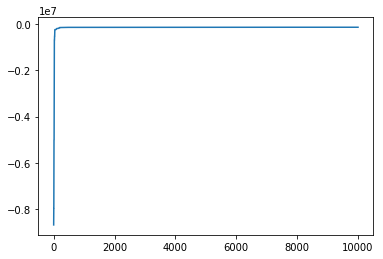

In [122]:
plt.plot(log_probs)

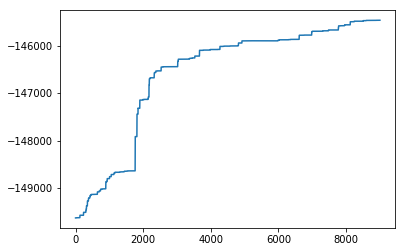

In [123]:
plt.plot(log_probs[1000:])

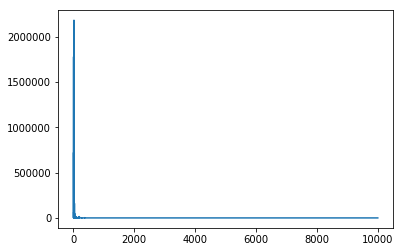

In [124]:
plt.plot(np.diff(log_probs))

In [125]:
traj.shape

(10001, 20)

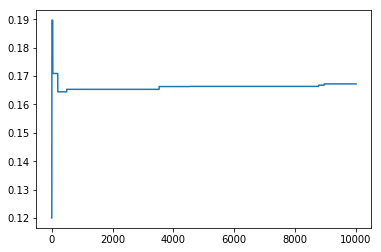

In [126]:
plt.plot(traj[:,0])

In [127]:
sum(np.diff(traj[:,0]) != 0)

8

In [128]:
sum(np.diff(traj[:,1]) != 0)

7

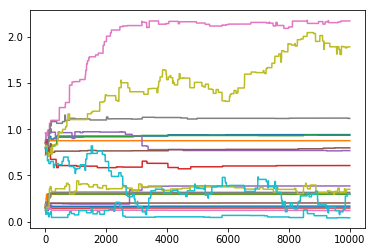

In [129]:
for t in traj.T:
    plt.plot(t)

In [130]:
max(log_probs)

-145467.93925994416

In [131]:
-log_probs[2000], - (-9.69e4)

(148801.97404769983, 96900.0)

In [132]:
log_probs[1000]

-149629.90125581107

In [133]:
traj[-1]

array([0.16722743, 0.29472079, 0.29758114, 0.14732922, 0.38569616,
       0.20141304, 0.11980026, 0.31574733, 0.34956249, 0.04065375,
       0.94198164, 0.87584112, 0.9347553 , 0.60682203, 0.76868487,
       0.79825814, 2.17277506, 1.11715885, 1.89180593, 0.29777577])

In [134]:
from sklearn.decomposition import PCA
pca = PCA()

In [135]:
pca.fit(traj)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

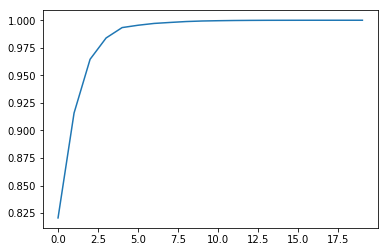

In [136]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [137]:
y = pca.transform(traj)

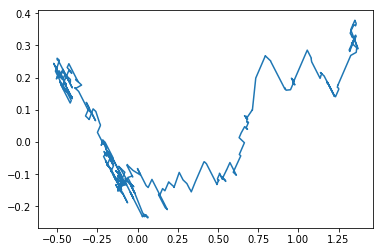

In [138]:
plt.plot(y[:,0], y[:,1])

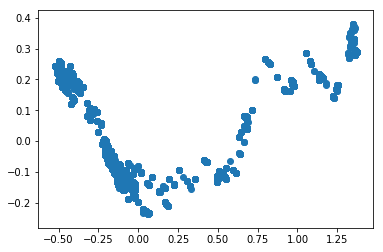

In [139]:
plt.scatter(y[:,0], y[:,1])

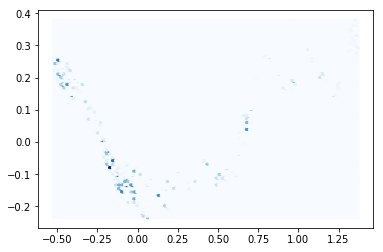

In [140]:
plt.hexbin(y[:,0], y[:,1], cmap='Blues')

In [141]:
from bayes_implicit_solvent.molecule import Molecule

In [96]:
from pkg_resources import resource_filename
import mdtraj as md
from bayes_implicit_solvent.utils import mdtraj_to_list_of_unitted_snapshots
alkanes = ['C' * i for i in range(1, 11)]

mols = []
hydrogens = []

n_configuration_samples = 100

for smiles in alkanes:
    mol = Molecule(smiles, vacuum_samples=[])
    path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                               'vacuum_samples/vacuum_samples_{}.h5'.format(
                                                   mol.mol_index_in_smiles_list))
    vacuum_traj = md.load(path_to_vacuum_samples)
    thinning = int(len(vacuum_traj) / n_configuration_samples)
    mol.vacuum_traj = mdtraj_to_list_of_unitted_snapshots(vacuum_traj[::thinning])
    print('thinned vacuum_traj from {} to {}'.format(len(vacuum_traj), len(mol.vacuum_traj)))
    hydrogens.append(np.array([a.element.symbol == 'H' for a in mol.top.atoms()]))
    mols.append(mol)

thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100


In [97]:
def unpack(theta):
    n = int((len(theta)) / 2)
    radii, scales = theta[:n], theta[n:2 * n]
    return radii, scales

In [98]:
radii, scales = unpack(traj[-1])

In [99]:
radii

array([0.07566444, 0.16883734, 0.09338138, 0.27293767, 0.1798142 ,
       0.18011829, 0.20057982, 0.14543918, 0.23531274, 0.22513847])

In [100]:
scales

array([1.40783043, 0.86054767, 1.58351549, 0.32474714, 0.91111293,
       1.05334199, 1.08102036, 1.2532967 , 1.04593183, 0.76424206])

In [101]:
elements = []
all_elements = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]
element_dict = dict(zip(all_elements, list(range(len(all_elements)))))
for mol in mols:
    elements.append(np.array([a.element.atomic_number for a in mol.top.atoms()]))

In [102]:
def construct_array(i, theta):
    radii, scales = unpack(theta)

    mol_radii = np.array([radii[element_dict[element]] for element in elements[i]])
    mol_scales = np.array([scales[element_dict[element]] for element in elements[i]])
    return mol_radii, mol_scales

def construct_arrays(theta):
    arrays = [construct_array(i, theta) for i in range(len(mols))]
    mol_radii = [a[0] for a in arrays]
    mol_scales = [a[1] for a in arrays]
    return mol_radii, mol_scales
mol_radii, mol_scales = construct_arrays(traj[-1])

In [103]:
mol = mols[0]
radii = mol_radii[0]
scales = mol_scales[0]

In [104]:
mol.predict_solvation_free_energy(radii, scales)

(1.4092712798677343, 0.002485497590669185)

In [105]:
mol.experimental_value, mol.experimental_uncertainty

(3.375609170943315, 0.3375609170943315)

In [108]:
thinned_traj = traj[::10]
len(thinned_traj)

201

In [109]:
all_pred_means = []
all_pred_uncs = []

expt_means, expt_uncs = [], []
for i in range(len(mols)):
    mol = mols[i]
    expt_mean, expt_unc = mol.experimental_value, mol.experimental_uncertainty
    
    expt_means.append(expt_mean)
    expt_uncs.append(expt_unc)

for i in range(len(mols)):
    mol = mols[i]
    expt_mean, expt_unc = mol.experimental_value, mol.experimental_uncertainty
    
    pred_means, pred_uncs = [], []
    
    for t in thinned_traj:
        mol_radii, mol_scales = construct_arrays(t) 
        radii = mol_radii[i]
        scales = mol_scales[i]

        pred_mean, pred_unc = mol.predict_solvation_free_energy(radii, scales)
        pred_means.append(pred_mean)
        pred_uncs.append(pred_unc)
    all_pred_means.append(np.array(pred_means))
    all_pred_uncs.append(np.array(pred_uncs))

In [110]:
expt_means, expt_uncs = [], []
for i in range(len(mols)):
    mol = mols[i]
    expt_mean, expt_unc = mol.experimental_value, mol.experimental_uncertainty
    
    expt_means.append(expt_mean)
    expt_uncs.append(expt_unc)

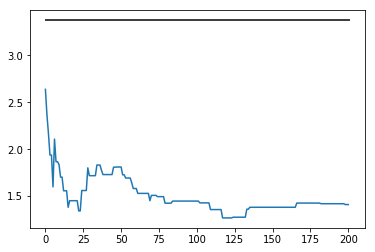

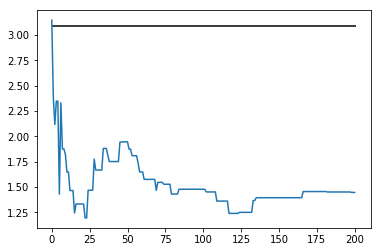

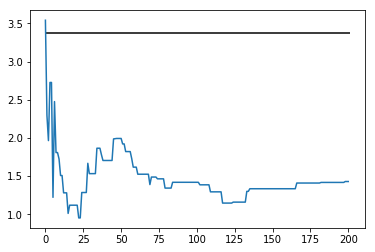

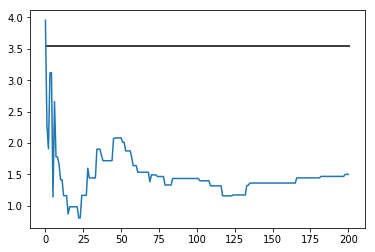

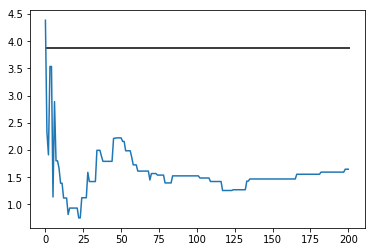

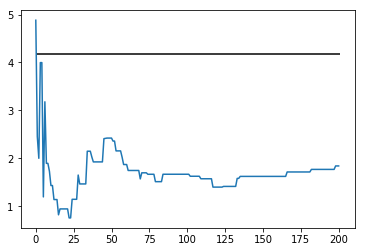

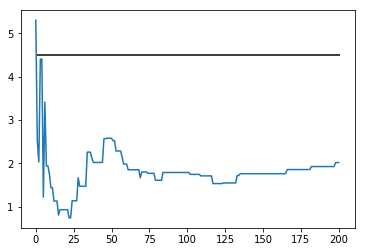

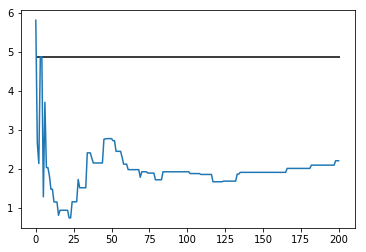

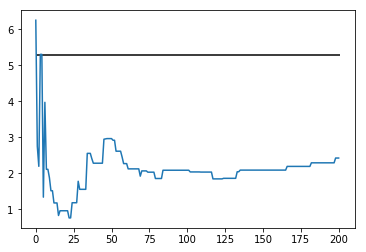

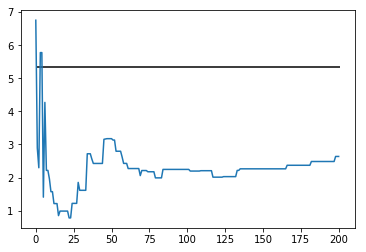

In [111]:
for i in range(len(mols)):
    plt.figure()
    plt.plot(all_pred_means[i])
    plt.hlines(expt_means[i], 0, len(all_pred_means[i]))

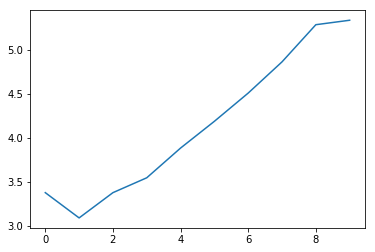

In [112]:
plt.plot(expt_means)

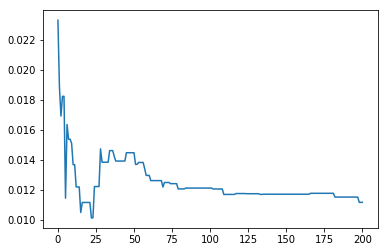

In [114]:
plt.plot(all_pred_uncs[-1])